## Home work 1

Алина Шаймарданова, БКЛ152

Я знаю, что моего мнения никто не спрашивал, но я обязана отметить, что само по себе задание вроде как не сложное. Но самая большая проблема -- это разобраться в инструкции. Мне кажется, что если я что-то сделала совершенно не то, что было нужно, то это "лыжи не едут".. Прошу прощения, но я должна была это написать.

## 1.1

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import pymorphy2
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

token = RegexpTokenizer('\w+')
morphy = pymorphy2.MorphAnalyzer()

In [3]:
words = []

with open('/Users/alinashaymardanova/Downloads/unesennye-vetrom.txt','r', encoding = 'Windows-1251') as f:
    for line in f:
        for word in token.tokenize(line):
            word = re.sub('\n','', word)
            word = re.sub('«','', word)
            words.append(word)

with open('/Users/alinashaymardanova/Downloads/kap_1.txt','r') as f:
    for line in f:
        for word in token.tokenize(line):
            word = re.sub('\n','', word)
            word = re.sub('«','', word)
            words.append(word)


+ Для последующего анализа приводим слова к нормальным формам -- леммам с помощью pymorphy2

In [4]:
lem_words = []

for el in words:
    lem_words.append(morphy.normal_forms(el)[0])


+ Так как в задании 1.1 необходимо проанализировать только один текст, откроем его отдельно и также приведем все слова к нормальным формам.

In [5]:
part_words = []

with open('/Users/alinashaymardanova/Downloads/kap_1.txt','r') as f:
    for line in f:
        for word in token.tokenize(line):
            word = re.sub('\n','', word)
            word = re.sub('«','', word)
            part_words.append(word)


In [6]:
lem_part_words = []
for el in part_words:
    lem_part_words.append(morphy.normal_forms(el)[0])


+ **TF-IDF**

In [7]:
from __future__ import division
import string
import math

tokenize = lambda doc: doc.lower().split(" ")

+ Почистим от всего ненужного:

In [8]:
f = open('/Users/alinashaymardanova/Downloads/kap_1.txt','r')
text = f.read()
text = re.sub('\n','', text)
text = re.sub('«|»|,|;|\.|\:','', text)
table = str.maketrans({ch: None for ch in string.punctuation})
[word.translate(table) for word in text.split()][2:10]


['Скарлетт', 'ОХара', 'не', 'была', 'красавицей', 'но', 'мужчины', 'вряд']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

def inverse_document_frequencies(tokenized_documents):
    idf_values = {}
    all_tokens_set = set([item for sublist in tokenized_documents for item in sublist])
    for tkn in all_tokens_set:
        contains_token = map(lambda doc: tkn in doc, tokenized_documents)
        idf_values[tkn] = 1 + math.log(len(tokenized_documents)/(sum(contains_token)))
    return idf_values

def sublinear_term_frequency(term, tokenized_document):
    count = tokenized_document.count(term)
    if count == 0:
        return 0
    return 1 + math.log(count)

def tfidf(documents):
    res = ''
    tokenized_documents = [tokenize(d) for d in documents]
    idf = inverse_document_frequencies(tokenized_documents)
    tfidf_documents = []
    for document in tokenized_documents:
        doc_tfidf = []
        for term in idf.keys():
            tf = sublinear_term_frequency(term, document)
            doc_tfidf.append(tf * idf[term])
            co1.append(term)
            co2.append(tf * idf[term])
        tfidf_documents.append(doc_tfidf)


In [10]:
co1=[]
co2=[]
sklearn_tfidf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)
sklearn_representation = sklearn_tfidf.fit_transform([text])

tfidf_representation = tfidf([text])

+ Выводим с 35 по 50, потому что до 35 в основном предлоги, союзы и частицы.

In [11]:
df = pd.DataFrame({'Слово':co1, 'IPM':co2})
df_sort = df.sort_values(['IPM'], ascending= False)
df_sort[35:50]

,IPM,Слово
1297,2.791759,которой
42,2.609438,друг
83,2.609438,быть
1357,2.609438,они
944,2.609438,эта
176,2.609438,скарлетт
481,2.609438,их
328,2.386294,года
36,2.386294,тот
354,2.386294,тем


+ Откроем частотный словарь (после использования, схлопнула его для удобства):

In [12]:
freq = pd.read_csv('/Users/alinashaymardanova/Downloads/Freq2011/freqrnc2011.csv', sep='\t')

In [13]:
freq[freq['Freq(ipm)']>500.0].head()

,Lemma,PoS,Freq(ipm),R,D,Doc
0,а,conj,8198.0,100,97,32332
1899,без,pr,1018.8,100,98,16550
3007,более,adv,706.2,100,95,16514
3063,большой,a,944.4,100,97,17589
3642,бы,part,2322.4,100,97,19003


+ Сначала я пыталась руками выбрать ключевые слова, но потом решила всё таки сделать по уму, через tfidf:) Но всё равно частота в тексте получилась не сильно большой.

In [14]:
key_words = ['история', 'глаза', 'год', 'роман', 'друг', 'жизнь']

In [15]:
first_df = pd.DataFrame(columns=['Лемма', 'IPM', 'Частота в корпусе', 'Частоста в тексте'])
res = []
for word in key_words:
    freq_1 = list(freq[freq['Lemma'].str.contains(word)]['Freq(ipm)'])[0]
    freq_count1 = lem_words.count(word)
    freq_count2 = part_words.count(word)
    res.append([word, freq_1, freq_count1, freq_count2])

for i in range(len(res)):
    first_df.loc[i] = res[i]
first_df

,Лемма,IPM,Частота в корпусе,Частоста в тексте
0,история,443.9,50,4
1,глаза,1.7,0,4
2,год,1.5,397,4
3,роман,1.2,37,4
4,друг,503.2,427,5
5,жизнь,1389.8,528,2


In [16]:
f = open('HW1_Shaimardanova_KeyWords.txt', 'w', encoding = 'utf-8')
first_df.to_csv(f, header=None, index=None, sep=' ')

Топ-500 для задания:

In [17]:
freq_sort = freq.sort_values(['Doc'], ascending= False)
top5 = freq_sort[:500]
top5[top5['Lemma']=='жизнь']

,Lemma,PoS,Freq(ipm),R,D,Doc
11456,жизнь,s,1389.8,100,96,14894


In [18]:
top5[top5['Lemma']=='год']

,Lemma,PoS,Freq(ipm),R,D,Doc
8015,год,s,3727.5,100,94,29477


In [19]:
top5[top5['Lemma']=='друг']

,Lemma,PoS,Freq(ipm),R,D,Doc
10701,друг,s,874.2,100,97,9689


In [20]:
top5[top5['Lemma']=='глаз']

,Lemma,PoS,Freq(ipm),R,D,Doc
7824,глаз,s,857.6,100,93,7664


In [21]:
top5[top5['Lemma']=='история']

,Lemma,PoS,Freq(ipm),R,D,Doc
15173,история,s,443.9,100,94,9150


In [22]:
top5[top5['Lemma']=='роман']

,Lemma,PoS,Freq(ipm),R,D,Doc


## 1.2

In [23]:
def parts(i, j):
    for k in range(0, len(i), j):
        yield i[k:k+j]

+ Добавляем в key_words ещё 3 частотных слова из словаря: 'знать', 'время', 'человек'

In [24]:
key_words = ['история', 'глаз', 'год', 'роман', 'друг', 'жизнь', 
             'литература','время', 'человек']

Насколько я поняла, чтобы сделать это задание нужно проанализировать ещё несколько текстов из коллекции. Для этого, я разделила свой изначальный большой текст на 5 под-частей и проанализировала их.

In [25]:
col= ['Слово', 'Подчасть_1', 'Подчасть_2', 'Подчасть_3', 'Подчасть_4', 'Подчасть_5']
second_df = pd.DataFrame(columns = col)
lem_parts = list(parts(lem_words, len(lem_words)//10))

In [26]:
for i in range(len(key_words)):
    counts = []
    counts.append(key_words[i])
    for j in range(5):
        counts.append(lem_parts[j].count(key_words[i]))
    second_df.loc[i] = counts


In [27]:
second_df

,Слово,Подчасть_1,Подчасть_2,Подчасть_3,Подчасть_4,Подчасть_5
0,история,15,1,4,1,1
1,глаз,101,99,79,96,95
2,год,79,58,40,13,30
3,роман,21,1,0,0,1
4,друг,39,36,37,27,35
5,жизнь,58,62,29,29,59
6,литература,14,0,0,0,0
7,время,44,49,37,44,65
8,человек,73,88,77,44,82


+ Найдите тексты, удовлетворяющие запросу Word1&Word2&¬Word3

**Друг&Война¬Роман = Часть_3 и Часть_4**

+ Для всей коллекции

In [28]:
text = ''.join(lem_words)

In [29]:
sklearn_tfidf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)
sklearn_representation = sklearn_tfidf.fit_transform([text])

tfidf_representation = tfidf([text])

In [30]:
df_new = pd.DataFrame({'Слово':co1, 'IPM':co2})
df_sort_new = df.sort_values(['IPM'], ascending= False)

In [31]:
df_sort_new.loc[df_sort_new['Слово'].isin(key_words)]


,IPM,Слово
42,2.609438,друг
471,2.386294,год
1381,2.386294,история
1453,2.098612,роман
1003,1.693147,время
1005,1.693147,жизнь
84,1.000000,литература
148,1.000000,человек


## 1.3

In [32]:
lem_parts = list(parts(lem_words, len(lem_words)//250))

+ Ищем наименее частотные слова в тексте:

In [33]:
freq_df = pd.DataFrame(columns=['Лемма', 'Частоста в тексте'])
res_13 = []

for word in lem_part_words:
    res_13.append([word, part_words.count(word)])

for i in range(len(res_13)):
    freq_df.loc[i] = res_13[i]


+ Схлопнула его для удобства

In [34]:
freq_df[freq_df['Частоста в тексте'] == 1].head()

,Лемма,Частоста в тексте
10,вряд,1
19,подобно,1
41,крупный,1
54,невольно,1
58,взгляд,1


+ Топ-100 слов из частотного словаря:

In [35]:
pos=['v','s','a']
freq_sort = freq.sort_values(['Doc'], ascending= False)
freq_sort.loc[freq_sort['PoS'].isin(pos)][:100]

,Lemma,PoS,Freq(ipm),R,D,Doc
3683,быть,v,12160.7,100,98,34184
8015,год,s,3727.5,100,94,29477
21708,мочь,v,2912.3,100,98,25413
5955,время,s,2015.7,100,97,24342
43800,стать,v,1621.8,100,97,21235
25279,новый,a,1217.5,100,96,21161
49992,человек,s,2723.0,100,97,20423
9304,дело,s,1412.1,100,97,18240
37358,работа,s,1058.3,100,95,18222
3063,большой,a,944.4,100,97,17589


+ шесть ключевых слов: 'девушка', 'война', 'мужчина', 'рабство', 'литература', 'молодой', 'год'
+ два частотных слова из топ-100 по частотному словарю: 'знать', 'человек'
+ два редких слова: 'зрелище', 'соприкосновение'


In [36]:
key_words = ['генерал', 'война', 'год', 'роман', 'друг', 'жизнь', 
          'знать', 'человек',
          'зрелище', 'соприкосновение']


In [37]:
res = []

for word in key_words:
    freq_1 = list(freq[freq['Lemma'].str.contains(word)]['Freq(ipm)'])[0]
    freq_count1 = lem_words.count(word)/len(lem_words)
    freq_count2 = lem_part_words.count(word)
    tf = freq_count2/len(lem_part_words)
    res.append([word, freq_1, freq_count1, freq_count2, tf])

pd.DataFrame(res, columns=['Слово', 
                           'Частота лексемы по частотному словарю', 
                           'Частота лексемы во всей коллекции', 
                           'Абсолютная частота слова в тексте', 
                           'Относительная частота'])

,Слово,Частота лексемы по частотному словарю,Частота лексемы во всей коллекции,Абсолютная частота слова в тексте,Относительная частота
0,генерал,140.0,0.000309,3,0.001248
1,война,425.9,0.000969,5,0.002081
2,год,1.5,0.001005,16,0.006658
3,роман,1.2,0.000094,11,0.004578
4,друг,503.2,0.001081,12,0.004994
5,жизнь,1389.8,0.001336,7,0.002913
6,знать,0.7,0.002445,7,0.002913
7,человек,1.1,0.002356,5,0.002081
8,зрелище,22.8,0.000046,1,0.000416
9,соприкосновение,6.4,0.000010,1,0.000416


In [38]:
tf_idf_data = []

def foo(word):
    i = 0
    for element in lem_parts:
        if word in element:
            i += 1
    return i

for word in key_words:
    count_w = lem_part_words.count(word)
    count_doc = foo(word)
    length_doc = len(lem_part_words)
    tf = count_doc/len(lem_part_words)
    idf = np.square(np.log10(10/count_doc))
    tf_idf = tf*idf
    tf_idf_data.append([word, count_w, length_doc, tf, count_doc, idf, tf_idf])

In [39]:
res = pd.DataFrame(tf_idf_data, columns=['word', 'Count(w)','LengthDoc', 'tf', 'Count(doc)', 'idf', 'tf*idf'])

In [40]:
res.sort_values(['tf*idf'], ascending=False)

,word,Count(w),LengthDoc,tf,Count(doc),idf,tf*idf
6,знать,7,2403,0.097378,234,1.874752,0.182560
7,человек,5,2403,0.094465,227,1.838806,0.173703
5,жизнь,7,2403,0.082397,198,1.681341,0.138537
2,год,16,2403,0.064919,156,1.423546,0.092415
4,друг,12,2403,0.062006,149,1.376366,0.085343
1,война,5,2403,0.058261,140,1.313609,0.076532
0,генерал,3,2403,0.020807,50,0.488559,0.010166
8,зрелище,1,2403,0.006658,16,0.041665,0.000277
9,соприкосновение,1,2403,0.001665,4,0.158356,0.000264
3,роман,11,2403,0.004161,10,0.000000,0.000000


In [42]:
f = open('HW1_Shaimardanova_WordListTest.txt', 'w', encoding = 'utf-8')
txt = res.sort_values(['tf*idf'], ascending=False)
txt.to_csv(f, header=None, index=None, sep=' ')

# 1.4 

In [43]:
def chunks(lst, chunk_count):
    chunk_size = len(lst) // chunk_count
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

f = open('/Users/alinashaymardanova/Downloads/unesennye-vetrom.txt','r', encoding = 'Windows-1251')
f = f.read()

part = chunks(f, 10)

In [44]:
key_words = ['друг', 'глаза', 'год', 'который']

In [45]:
df = pd.DataFrame()
for word in key_words:
    q = []
    for text in part:
        q.append(Counter(text.split())[word]/len(text))
    df[word] = q

In [46]:
df = df.drop(10, axis=0)
df

,друг,глаза,год,который
0,0.000048,0.000108,0.000040,0.000096
1,0.000052,0.000092,0.000052,0.000052
2,0.000048,0.000076,0.000024,0.000076
3,0.000040,0.000096,0.000004,0.000072
4,0.000032,0.000116,0.000012,0.000096
5,0.000024,0.000116,0.000028,0.000092
6,0.000036,0.000036,0.000012,0.000187
7,0.000056,0.000100,0.000008,0.000080
8,0.000040,0.000092,0.000012,0.000120
9,0.000052,0.000120,0.000008,0.000132


In [47]:
import matplotlib.pyplot as plt

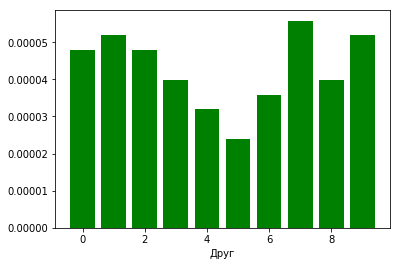

In [48]:
plt.bar(np.arange(10), df['друг'], color = 'green')
plt.xlabel('Друг')
plt.show()

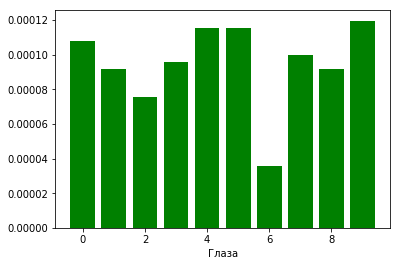

In [49]:
plt.bar(np.arange(10), df['глаза'], color = 'green')
plt.xlabel('Глаза')
plt.show()

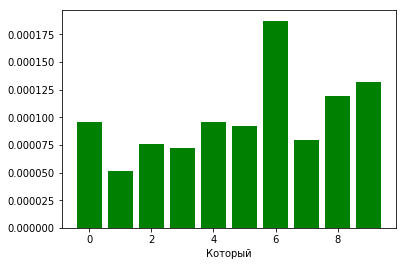

In [50]:
plt.bar(np.arange(10), df['который'], color = 'green')
plt.xlabel('Который')
plt.show()

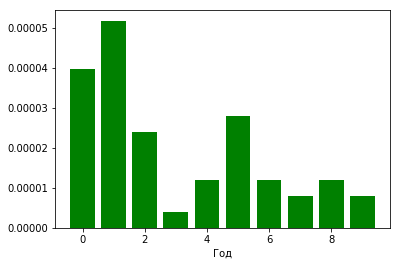

In [51]:
plt.bar(np.arange(10), df['год'], color = 'green')
plt.xlabel('Год')
plt.show()